# Finetuning DziriBERT for Dialect Detection

In [4]:
!nvidia-smi

Sun Dec 25 22:13:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install -q transformers
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd 

from sklearn.model_selection import train_test_split

from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import transformers
from transformers import BertTokenizerFast, BertModel, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup

In [50]:
# mount colab
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
path = Path('/content/drive/MyDrive/NLP DB/')

### MSDA Dialect Detection Dataset

In [13]:
df = pd.read_csv(path/'dialcet_db.csv')
df.sample(5)

,Unnamed: 0,Twits,dialect
62088,15266,هداك الله يا شيخ. قول خيرا او أصمت صوت الأذان ...,saudi_arabia
171937,106587,واخا توريني حوايج الدراري الصغار، عفاك.,morocco
40335,40335,ياااا شدخللللل 😂😂😂😂😂,lebanon
138329,72979,NaN,NaN
122586,57236,NaN,NaN


In [14]:
df.columns
df.drop(['Unnamed: 0'], axis=1, inplace=True)


This is the number of training examples for each class in our dataset.

In [15]:
dfX = df
new_df = dfX[(dfX['dialect'] == 'morocco' ) | (dfX['dialect'] == 'algerian') | (dfX['dialect'] == 'lebanon' ) | (dfX['dialect'] == 'egypt') | (dfX['dialect'] == 'tunisian') | (dfX['dialect'] == 'qatar' ) | (dfX['dialect'] == 'iraq') | (dfX['dialect'] == 'libya') | (dfX['dialect'] == 'saudi_arabia' ) | (dfX['dialect'] == 'jordan')]
lebanon = new_df[new_df['dialect'] == 'lebanon'][:12234]
egypt = new_df[new_df['dialect'] == 'egypt'][:12234]
morocco = new_df[new_df['dialect'] == 'morocco'][:12234]
tunisian = new_df[new_df['dialect'] == 'tunisian'][:12234]
algerian = new_df[new_df['dialect'] == 'algerian'][:12234]
qatar = new_df[new_df['dialect'] == 'qatar'][:12234]

iraq = new_df[new_df['dialect'] == 'iraq']
saudi_arabia = new_df[new_df['dialect'] == 'saudi_arabia']
libya = new_df[new_df['dialect'] == 'libya']
jordan = new_df[new_df['dialect'] == 'jordan']

frames = [lebanon, egypt, morocco, tunisian, algerian, qatar, iraq, saudi_arabia, libya, jordan]
df = pd.concat(frames)





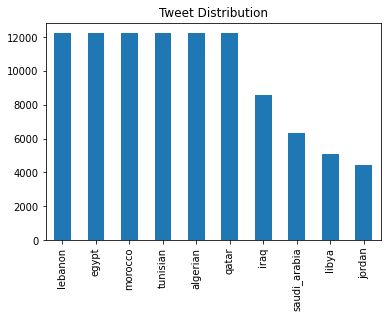

In [16]:
df.dialect.value_counts().plot.bar(x=df.dialect.unique(), title='Tweet Distribution')

We encode the labels by mapping each dialect to an index.

In [17]:
dialects = df['dialect'].unique()

lbl2idx = {d: i for i, d in enumerate(dialects)}

df['dialect'] = df['dialect'].map(lbl2idx)

In [18]:
df['dialect'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We split the dataset randomly, 70% will be used for training, and 30% for validation and testing of the model.

In [19]:
df['dialect'].value_counts()

0    12234
1    12234
2    12234
3    12234
4    12234
5    12234
6     8556
7     6312
8     5070
9     4426
Name: dialect, dtype: int64

In [20]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Twits'], df['dialect'], random_state=42, 
                                                                    test_size=0.3)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, random_state=42, 
                                                                test_size=0.5)

len(train_texts), len(val_texts), len(test_texts)

(68437, 14665, 14666)

In [21]:
BERT_MODEL_NAME = 'alger-ia/dziribert'

tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/176 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/620 [00:00<?, ?B/s]

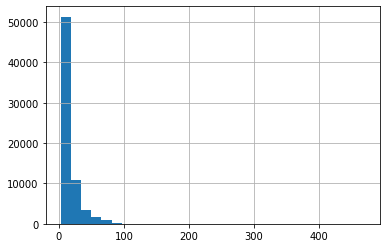

In [22]:
seq_len = [len(tokenizer.encode(i)) for i in train_texts]

pd.Series(seq_len).hist(bins = 30)

In [23]:
max_seq_len = 40

train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, return_token_type_ids=False, max_length=max_seq_len)
val_encodings = tokenizer(val_texts.to_list(), truncation=True, padding=True, return_token_type_ids=False, max_length=max_seq_len)
test_encodings = tokenizer(test_texts.to_list(), truncation=True, padding=True, return_token_type_ids=False, max_length=max_seq_len)

In [24]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.to_list()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)

In [25]:
train_dataset[0]

{'input_ids': tensor([    2,  4351, 26664,  1818,  4812, 17044,  2361,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(1)}

Notice i'm using `macro` instead of `micro` as in the blog which was mainly to compare with MSDA paper.

In [26]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(preds, labels):
    preds = preds.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [27]:
model = BertModel.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You s

In [28]:
out = tokenizer.encode_plus(train_texts.to_list()[0], return_token_type_ids=False, return_tensors='pt')

model.eval()
with torch.no_grad():
  bert_out = model(out['input_ids'], out['attention_mask'])

Bert has two outputs, first is the vector of size 768 for each input token, bellow there 20 tokens, the second output is the representation (hidden state) of `[CLS]` token. 

In [29]:
len(bert_out), bert_out[0].shape, bert_out[1].shape

(2, torch.Size([1, 8, 768]), torch.Size([1, 768]))

The pooler output is the representation of `[CLS]` token run through a linear layer followed by tanh activation function, and it's the one we gonna use for sequence classification.

In [30]:
bert_out.pooler_output.shape

torch.Size([1, 768])

In [31]:
class TweetDataModule(pl.LightningDataModule):
  def __init__(self, train_ds, val_ds, test_ds, batch_size=32):
    super().__init__()
    self.batch_size = batch_size
    self.train_dataset = train_ds
    self.val_dataset = val_ds
    self.test_dataset = test_ds


  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      )
  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size
      )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      )

In [32]:
tweet_datamodule = TweetDataModule(train_dataset, val_dataset, test_dataset)

In [33]:
class TweetModule(pl.LightningModule):
  def __init__(self, n_classes, n_warmup_steps, n_training_steps, compute_metrics):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.criterion = nn.CrossEntropyLoss()
    self.n_warmup_steps = n_warmup_steps
    self.n_training_steps = n_training_steps
    self.compute_metrics = compute_metrics

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask)
    output = self.classifier(output.pooler_output)                    
    # if provided with labels return loss and output
    if labels is not None:
      loss = self.criterion(output, labels)
      return loss, output 
    return output

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    # self will call the forward method 
    loss, preds = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, preds = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
    return {"loss": loss, "predictions": preds, "labels": labels}
  
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, preds = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
    return {"loss": loss, "predictions": preds, "labels": labels}

  def validation_epoch_end(self, val_outputs):
    labels = []
    predictions = []
    for output in val_outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    metrics = self.compute_metrics(predictions, labels)
    self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)         # log metrics at end of validation epoch and put them on progress bar

  def test_epoch_end(self, test_outputs):
    labels = []
    predictions = []
    for output in test_outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    metrics = self.compute_metrics(predictions, labels)
    self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
  
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=5e-5, weight_decay=0.01)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=self.n_warmup_steps,
                                                num_training_steps=self.n_training_steps
                                                )
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

In [34]:
# number of train steps is number of steps in one epoch multiplied by number of epochs
NUM_EPOCH = 5
n_warmup_steps = 500
n_training_steps = NUM_EPOCH*(len(tweet_datamodule.train_dataloader()))
n_training_steps

10695

In [40]:
model = TweetModule(n_classes=10, 
                    n_warmup_steps=n_warmup_steps, 
                    n_training_steps=n_training_steps, 
                    compute_metrics=compute_metrics
                    )

trainer = pl.Trainer(max_epochs=NUM_EPOCH, gpus=1, gradient_clip_val=1.)
trainer.fit(model, datamodule=tweet_datamodule)

Some weights of the model checkpoint at alger-ia/dziribert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You s

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [54]:
model_save_name = 'dialect_classifier.pt'
path = F"/content/drive/MyDrive/NLP DB/{model_save_name}" 
torch.save(model.state_dict(), path)

In [63]:
device = torch.device("cpu")


In [66]:
#model = model.to(device)
#model = bert_classifier   
def predict(review_text):
    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=123,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='longest',
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    #print(f'Review text: {review_text}')
    index = output.cpu().data.numpy().argmax()
    #print(f'Sentiment  : {index}')
    return index


dfM = pd.DataFrame({
            'texts': ['بالله ريحي جمالك وخطي الخوض الشرع جو يهله والهي بمجتمعكن الماساوي اللي مسمياته نسوي', 'فعلا الرجل عاله وقت توا نساء العالم الناجحات توا اما مطلقه اما عايشه الرجل توا رجاله عبء وخلاص']
        })

results = dfM.apply(lambda l: predict(l.texts), axis=1)



In [67]:
results

0    3
1    8
dtype: int64